In [1]:
from gdeep.topactivation import TopactivationFC as TFC
from gdeep.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter
import numpy as np 
from gdeep.models import FFNet
from torch import nn
import torch
from gdeep.data import TorchDataLoader
from tqdm import tqdm 


from gdeep.models import ModelExtractor
import matplotlib.pyplot as plt 

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU!")
else:
    DEVICE = torch.device("cpu")


def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')
    
    
from gdeep.topactivation.svr import SVR



Using GPU!
Using GPU!
Using GPU!
No TPUs...
Using GPU!


In [271]:


import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16',pretrained=True)

import cProfile
weights= [ w.detach() for w in model.parameters() ]


for w in weights:
    if len(w.shape)>1:
        print(w.shape)
        
svr = SVR(weights,method='svr',max_modes=200)


Using cache found in /home/meller/.cache/torch/hub/pytorch_vision_v0.10.0


torch.Size([64, 3, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([256, 128, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([512, 256, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([4096, 25088])
torch.Size([4096, 4096])
torch.Size([1000, 4096])


100%|███████████████████████████████████████████| 16/16 [00:58<00:00,  3.66s/it]


In [272]:
svr.plot()

100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.34it/s]


In [4]:
import torch.nn as nn 
class Truncated(nn.Module):
    def __init__(self,model,trunc_idx):
        super(Truncated, self).__init__()    
        model.eval()
        self.model = model
        self.trunc_idx = trunc_idx 
        self.arch = ""
        i = 0 
        conv_n = 0 
        for layer in model.named_modules():
            if i > self.trunc_idx:
                break
            if not ('VGG' in str(type(layer[1])) or 'Sequential' in str(type(layer[1]))):
                if 'conv' in str(type(layer[1])):
                    self.arch += str(i) +"-"+str(type(layer[1])).split('.')[3] +str(conv_n)+" \n"
                    conv_n+=1 
                else:
                    self.arch += str(i) +"-"+str(type(layer[1])).split('.')[3] +" \n"
                i+=1 
                
    def forward(self,x):
        idx = 0 
        for layer in model.named_modules():
            if idx >self.trunc_idx:
                return x 
            if not ('VGG' in str(type(layer[1])) or 'Sequential' in str(type(layer[1]))): 
                #print(type(layer[1]),x.shape)
                x = layer[1](x)
                idx+=1 
        return x 

In [5]:
from torchvision import datasets, models, transforms
import os 

data_transforms = {
    'imagenet-sample-images': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = '/home/meller/Documents/imagenet/'
data = datasets.ImageFolder(data_dir,data_transform)
#image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]for x in ['imagenet-sample-images']}
#dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4)

#dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [7]:
def convID2layerID(model,conv_idx):
    conv_n,i=0,0
    for layer in model.named_modules():
            if not ('VGG' in str(type(layer[1])) or 'Sequential' in str(type(layer[1]))):
                if 'conv' in str(type(layer[1])):
                    if conv_n==conv_idx:
                        return i 
                    conv_n+=1 
                    
                i+=1 

In [290]:
def print_images(idx,features=[0,1,2,10,-10,-1]):
    #imshow(data[idx][0])
    #plt.show()
    
    layers = list(range(5,11))
    
    columns = len(layers)
    rows = len(features)
    
    fig = plt.figure(figsize=(15, 10))
    w = 10
    h = 10
    i=1
    for feature in features:
        for conv_idx in layers:

            trunc_idx = convID2layerID(model,conv_idx)-1
            v= svr.V[conv_idx][:,:,:,feature].unsqueeze(0)
            x = data[idx][0].unsqueeze(0)

            trunc = Truncated(model,trunc_idx)
            y = trunc(x)
            img = torch.nn.functional.conv2d(y,v).detach()
            img = torch.abs(img.squeeze(0).squeeze(0))
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
            plt.axis('off')
            i+=1
    plt.show()
        
        
        

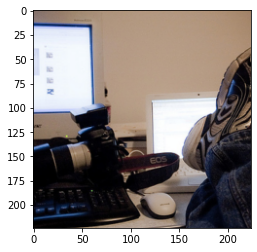

In [220]:
imshow(data[673][0])

607


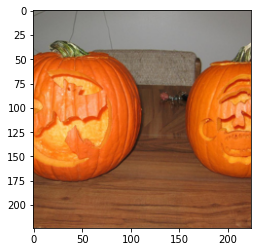

In [338]:
i = np.random.randint(1000)
print(i)
imshow(data[i][0])

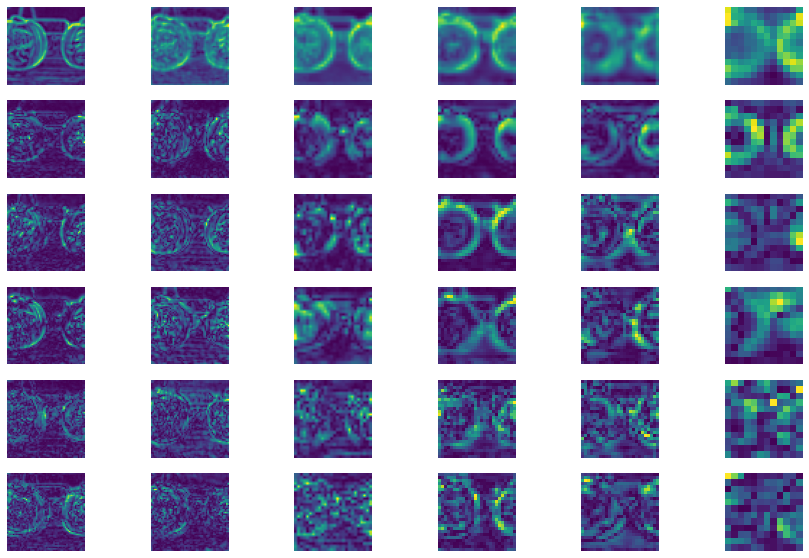

In [339]:
print_images(607)
#204

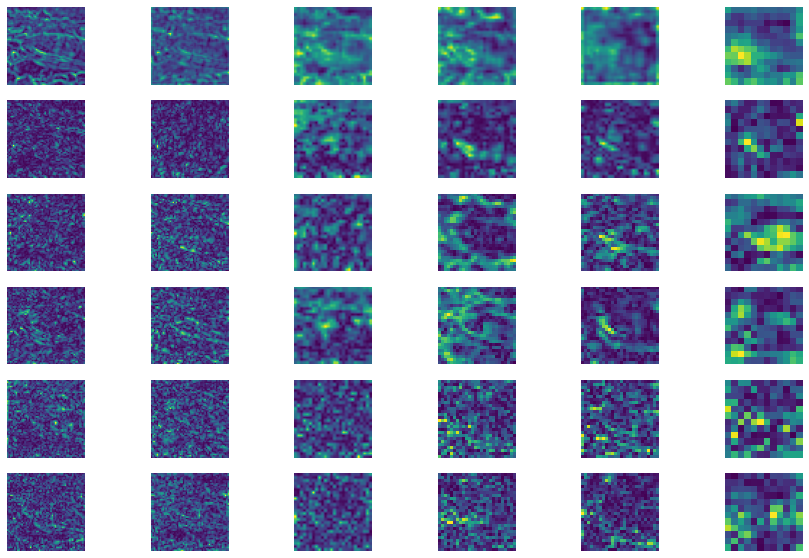

In [112]:
print_images(35)

## Node space

In [254]:
def print_images_nodes(idx,channels=[0,1,2,3,4]):
    #imshow(data[idx][0])
    #plt.show()
    
    layers = list(range(5,11))
    
    columns = len(layers)
    rows = len(channels)
    
    fig = plt.figure(figsize=(15, 10))
    w = 10
    h = 10
    i=1
    for channel in channels:
        for conv_idx in layers:

            trunc_idx = convID2layerID(model,conv_idx)-1
            x = data[idx][0].unsqueeze(0)

            trunc = Truncated(model,trunc_idx)
            y = trunc(x)
            img = y.squeeze(0).mean(dim=0).detach()
            img = torch.abs(img)
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
            plt.axis('off')
            i+=1
    plt.show()
        
        
        

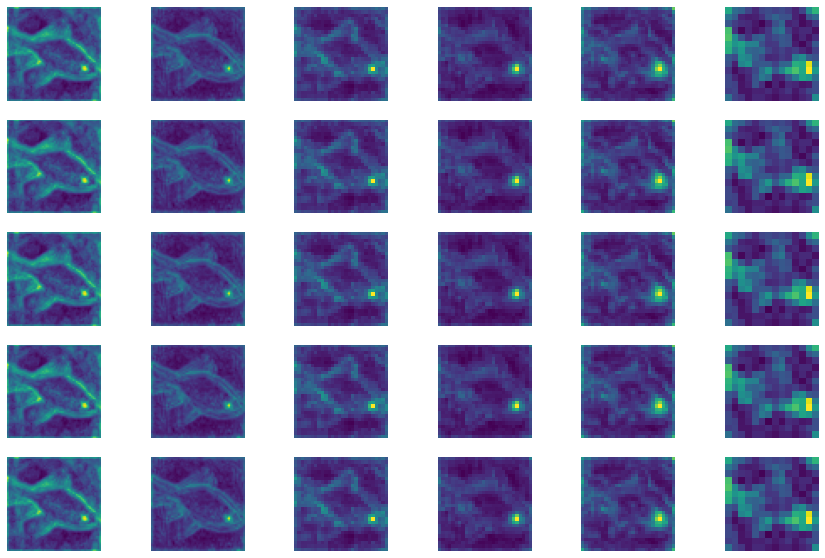

In [255]:
print_images_nodes(1)